In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split 
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import nltk

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', 100)

In [63]:
# import sys
# !{sys.executable} -m pip install nltk 
# !{sys.executable} -m pip install scikit-learn --upgrade

In [44]:
df = pd.read_csv('~/Desktop/maven_wave/Baker - Lending Club Data - DR_Demo_Lending_Club.csv',
                 index_col='Id',
                 parse_dates=['earliest_cr_line'],
                 dtype={'is_bad': bool})

# Remove 5 records with missing values
bad_ids = [4320, 4329, 4679, 6233, 7593]
df.drop(bad_ids, inplace=True)

In [45]:
df['pymnt_plan'] = df.pymnt_plan.map({'y': True, 'n': False})
print(f'dataset shape = {df.shape}')
print()
print('dtypes:')
print(df.dtypes.value_counts())

dataset shape = (9995, 27)

dtypes:
object            11
float64           11
int64              2
bool               2
datetime64[ns]     1
dtype: int64


In [46]:
# Distribution of response variable
df.is_bad.value_counts(normalize=True)

False    0.870435
True     0.129565
Name: is_bad, dtype: float64

In [47]:
# check for missing values
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)

mths_since_last_record        9155
mths_since_last_delinq        6311
Notes                         3230
emp_title                      589
collections_12_mths_ex_med      27
revol_util                      21
purpose                          4
dtype: int64

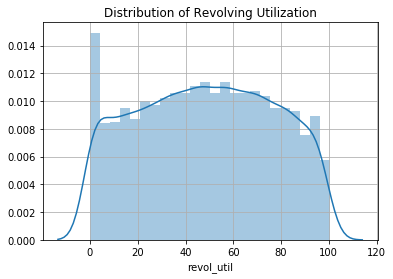

In [48]:
sns.distplot(df.revol_util.dropna());
plt.title('Distribution of Revolving Utilization')
plt.grid();

In [49]:
# Impute missing values
df.loc[df.revol_util.isna(), 'revol_util'] = df.revol_util.dropna().mean()
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)

mths_since_last_record        9155
mths_since_last_delinq        6311
Notes                         3230
emp_title                      589
collections_12_mths_ex_med      27
purpose                          4
dtype: int64

In [50]:
# Drop this column
print(df.collections_12_mths_ex_med.value_counts(dropna=False))
df.drop(columns=['collections_12_mths_ex_med'], inplace=True)

0.0    9968
NaN      27
Name: collections_12_mths_ex_med, dtype: int64


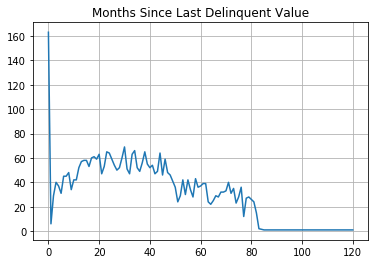

In [51]:
# Discretize this column
df.mths_since_last_delinq.value_counts(dropna=False).sort_index().plot(grid=True);
plt.title('Months Since Last Delinquent Value');

In [12]:
# integer_columns = ['emp_length', 
#                    'delinq_2yrs', 
#                    'inq_last_6mths', 
#                    'mths_since_last_delinq', 
#                    'mths_since_last_record', 
#                    'open_acc', 
#                    'total_acc', 
#                    'mths_since_last_major_derog']
# float_columns = ['debt_to_income', 
#                  'revol_bal', 
#                  'revol_util', 
#                  'annual_inc']
# bool_columns = ['is_bad',
#                 'pymnt_plan']
# obj_columns = ['emp_title', 
#                'home_ownership', 
#                'verification_status', 
#                'Notes', 
#                'purpose_cat', 
#                'purpose', 
#                'zip_code', 
#                'addr_state', 
#                'initial_list_status', 
#                'policy_code']
# df.loc[:, integer_columns] = df.loc[:, integer_columns].astype(int)

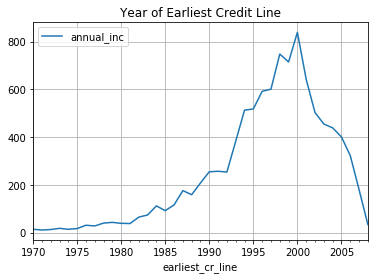

In [13]:
# Some featurization/data cleanup
df.loc[df.earliest_cr_line >= pd.to_datetime('2020-01-01'), 'earliest_cr_line'] = pd.NaT
# df['earliest_cr_cohort_year'] = df.earliest_cr_line.dt.strftime('%Y')
df.set_index('earliest_cr_line')['annual_inc'].resample('Y').size().plot()
plt.legend();
plt.grid()
plt.title('Year of Earliest Credit Line');

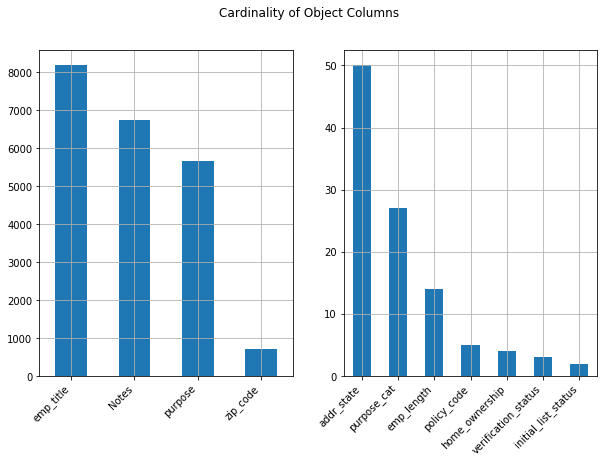

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
df.select_dtypes(include='object').nunique().sort_values(ascending=False).iloc[:4].plot(kind='bar', grid=True, ax=ax1)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

df.select_dtypes(include='object').nunique().sort_values(ascending=False).iloc[4:].plot(kind='bar', grid=True, ax=ax2)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.suptitle('Cardinality of Object Columns');
# plt.gcf().tight_layout()

In [64]:
def tokenize(text):
        """
        Tokenizes sequences of text and stems the tokens.
        :param text: String to tokenize
        :return: List with stemmed tokens
        """
        tokens = nltk.WhitespaceTokenizer().tokenize(text)
        tokens = list(set(re.sub("[^a-zA-Z\']", "", token) for token in tokens))
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        tokens = list(set(re.sub("[^a-zA-Z]", "", token) for token in tokens))
        stems = []
        stemmer = SnowballStemmer("english")
        for token in tokens:
            token = stemmer.stem(token)
            if token != "":
                stems.append(token)
        return stems 

In [66]:
df.purpose_cat.value_counts()

debt consolidation                   4454
credit card                          1273
other                                1021
home improvement                      800
major purchase                        546
small business                        461
car                                   349
wedding                               250
medical                               183
moving                                159
educational                           107
debt consolidation small business     102
vacation                               94
house                                  94
renewable energy                       19
other small business                   18
credit card small business             17
small business small business          12
home improvement small business        11
major purchase small business           5
educational small business              5
moving small business                   3
car small business                      3
house small business              

In [59]:
# Use Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,2), stop_words='english', strip_accents='ascii')
res = vectorizer.fit_transform(df.purpose.dropna())
print(len(vectorizer.get_feature_names()))
# df.purpose.value_counts().head(50)

8476


In [19]:
obj_cols_to_use = df.select_dtypes(include='object').nunique().sort_values(ascending=False).iloc[3:].index.values.tolist()
print(obj_cols_to_use)

['zip_code', 'addr_state', 'purpose_cat', 'emp_length', 'policy_code', 'home_ownership', 'verification_status', 'initial_list_status']


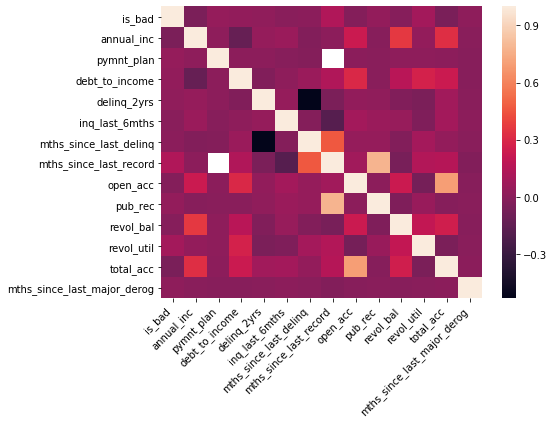

In [21]:
plt.figure(figsize=(8, 6))
corr = df.select_dtypes(include=[np.number, bool]).corr()
# sns.heatmap(corr, annot=False, cmap=plt.cm.Reds)
sns.heatmap(corr, annot=False)
plt.xticks(rotation=45, ha='right')
plt.gcf().tight_layout()

<Figure size 576x432 with 0 Axes>

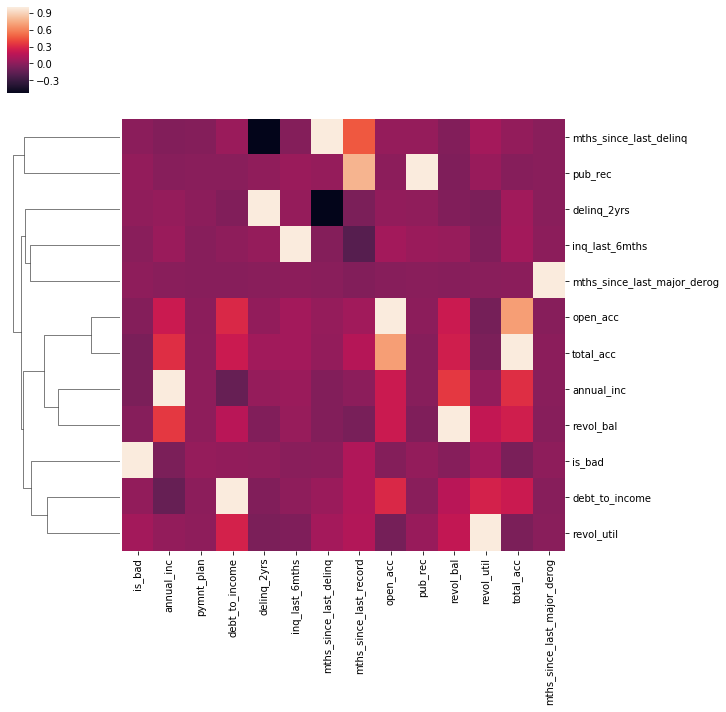

In [28]:
plt.figure(figsize=(8, 6));
sns.clustermap(corr.dropna(), col_cluster=False);
plt.xticks(rotation=45, ha='right');

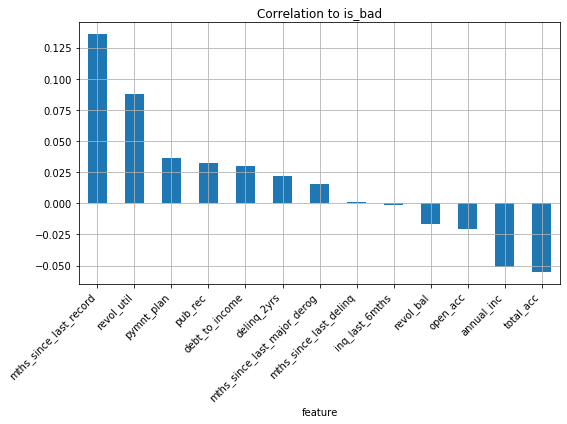

In [30]:
corr_2 = corr.unstack().to_frame('value').reset_index()
corr_2 = corr_2[corr_2.level_0 != corr_2.level_1]

tmp = corr_2[corr_2.level_0 == 'is_bad'].rename(columns={'level_1': 'feature'}).set_index('feature')[
    ['value']].sort_values('value', ascending=False)
tmp.plot(kind='bar', grid=True, legend=None, figsize=(8,6))
plt.title('Correlation to is_bad')
plt.xticks(rotation='45', ha='right')
plt.gcf().tight_layout()

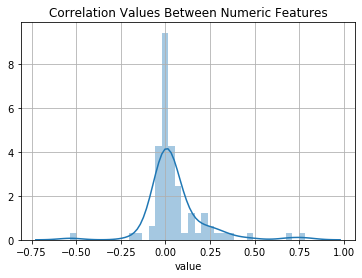

In [31]:
corr_2['features_set'] = corr_2.apply(lambda row: str(sorted([row.level_0, row.level_1])), axis=1)
corr_2 = corr_2.drop_duplicates(subset=['features_set']) \
    .drop(columns=['level_0', 'level_1']) \
    .sort_values('value', ascending=False).dropna()
sns.distplot(corr_2.value)
plt.title('Correlation Values Between Numeric Features')
plt.grid();

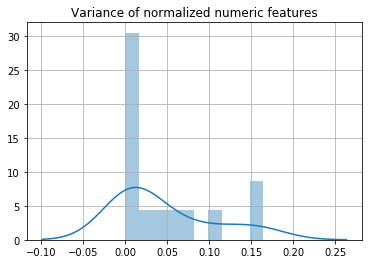

In [32]:
scaler = preprocessing.MinMaxScaler()
df_scale = pd.DataFrame(index=df.select_dtypes(include=[np.number, bool]).index,
                        data=scaler.fit_transform(df.select_dtypes(include=[np.number, bool])),
                        columns=df.select_dtypes(include=[np.number, bool]).columns)
sns.distplot(df_scale.var(), bins=10)
plt.title('Variance of normalized numeric features')
plt.grid()

In [34]:
# Examine feature variance
tmp_2 = (100 * df_scale.var().div(df_scale.var().max())).round(3).sort_values(ascending=False)
print(tmp_2)

mths_since_last_major_derog    100.000
mths_since_last_record          91.615
is_bad                          68.587
revol_util                      47.853
debt_to_income                  30.834
mths_since_last_delinq          21.116
total_acc                       10.526
open_acc                         8.629
pub_rec                          4.265
inq_last_6mths                   2.120
annual_inc                       1.780
delinq_2yrs                      1.288
revol_bal                        0.270
pymnt_plan                       0.122
dtype: float64


In [36]:
num_cols_to_use = tmp_2[tmp_2 >= 0].index.values.tolist()
print(num_cols_to_use)

['mths_since_last_major_derog', 'mths_since_last_record', 'is_bad', 'revol_util', 'debt_to_income', 'mths_since_last_delinq', 'total_acc', 'open_acc', 'pub_rec', 'inq_last_6mths', 'annual_inc', 'delinq_2yrs', 'revol_bal', 'pymnt_plan']


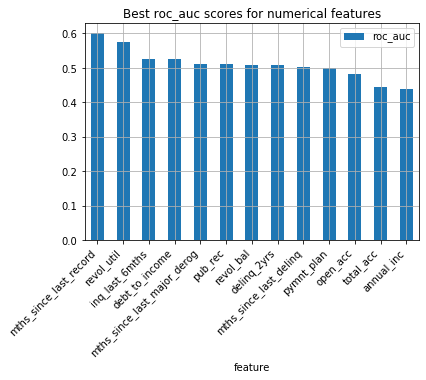

In [37]:
# Compute roc_auc score using numeric features
from sklearn.metrics import roc_auc_score
tmp_df = df[num_cols_to_use].copy()
tmp_df.drop(columns=['is_bad'], inplace=True)
l = []
# tmp_df.apply(lambda col: roc_auc_score(df.is_bad, col))
for col in tmp_df.iteritems():
    new_df = pd.DataFrame(data={'feature': col[1]})
    new_df['label'] = df['is_bad']
    new_df = new_df.dropna()
    val = roc_auc_score(new_df.label, new_df.feature)
    d = {'feature': col[0], 'roc_auc': val}
    l.append(d)
tmp_df_2 = pd.DataFrame(l).sort_values('roc_auc', ascending=False).set_index('feature')
tmp_df_2.plot(kind='bar', grid=True)
plt.xticks(rotation=45, ha='right')
plt.title('Best roc_auc scores for numerical features');

In [ ]:
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.datasets import load_iris
# from sklearn.feature_selection import SelectFromModel

In [ ]:
cols = sorted(obj_cols_to_use + num_cols_to_use)
print(cols)

In [ ]:
df_1 = df[cols].copy()
df_2 = pd.get_dummies(df_1)
df_2.shape

In [ ]:
varr = df_2.var().sort_values()
varr = varr[varr >= 0.01]
varr.shape

In [ ]:
df_2.isna().sum()[df_2.isna().sum() > 0].sort_values(ascending=False)

In [ ]:
from sklearn.impute import SimpleImputer
df_3 = pd.DataFrame(index=df_2.set_index('is_bad').index, 
                    columns=df_2.set_index('is_bad').columns,
                    data = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(df_2.set_index('is_bad')))
df_3.reset_index(inplace=True)

In [ ]:
X = df_3[varr.index.values.tolist()].copy().drop(columns=['is_bad'])
y = df_3[['is_bad']].copy()

In [ ]:
# Split into test and train and make sure evenly sampled data
X_train, X_test, y_train, y_test = train_test_split(X, y) 
print(f'y_train value counts = {y_train.is_bad.value_counts(normalize=True).loc[True]:0.2f}')
print(f'y_test value counts = {y_test.is_bad.value_counts(normalize=True).loc[True]:0.2f}')

In [ ]:
# clf = GaussianNB()
clf =  LogisticRegression()
clf.fit(X_train, y_train.values.flatten())
preds = y_test.copy()
preds['y_prob_lr'] = clf.predict_proba(X_test)[:, 1]

In [ ]:
# Print roc_auc score
print(f'roc auc score with LogisticRegression = {roc_auc_score(preds.is_bad, preds.y_prob_lr)}')

In [ ]:
# Try logistic regression
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train.values.flatten())
preds['y_prob_rf'] = clf.predict_proba(X_test)[:, 1]

In [ ]:
# Print roc_auc score
print(f'roc auc score with RandomForest = {roc_auc_score(preds.is_bad, preds.y_prob_rf)}')

In [ ]:
# Use Grid search to find best XGBoost parameters with stochastic column sampling using roc_auc for scoring
param_grid = {
    'n_estimators': [50, 100], 
    'max_depth': [5, 9], 
    'learning_rate': [0.01, 0.1, 0.25], 
    'colsample_bytree': [0.5, 1.0]
}
b = y_train.is_bad.value_counts()
scale_pos_weight = b.loc[False] / b.loc[True]
xgb_grid_clf = GridSearchCV(XGBClassifier(scale_pos_weight=scale_pos_weight),
                            param_grid,
                            cv=3,
                            verbose=10, 
                            scoring='roc_auc', 
                            n_jobs=-1)
xgb_grid_clf.fit(X_train, y_train)

In [ ]:
model = xgb_grid_clf.best_estimator_ 
params = xgb_grid_clf.best_params_ 
scores = xgb_grid_clf.cv_results_
print(f'best params found: {params}')

In [ ]:
y_test = y_test.copy()

In [ ]:
# Print classification report
y_test['y_pred'] = model.predict(X_test) 
y_test['y_prob'] = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test.is_bad, y_test.y_pred))

In [ ]:
# Print roc_auc score
print(f'roc auc score on test data = {roc_auc_score(y_test.is_bad, y_test.y_prob)}')

In [ ]:
plot_roc_curve(model, X_test, y_test.is_bad)
plt.grid()

In [ ]:
# Plot feature importances
tmp = pd.DataFrame(index=X_test.columns, 
                   data={'importance': model.feature_importances_}).sort_values('importance', ascending=False) 
# tmp[tmp.importance > 0].plot(kind='bar', grid=True, figsize=(12,10)) 
tmp.head(35).plot(kind='bar', grid=True, figsize=(12,10)) 
plt.xticks(rotation=45, ha='right');
plt.title('Feature Importances'); plt.gcf().tight_layout();

In [ ]:
# tmp.loc[num_cols_to_use].head(35).plot(kind='bar', grid=True, figsize=(12,10)) 
# plt.xticks(rotation=45, ha='right');
# plt.title('Feature Importances'); 
# plt.gcf().tight_layout();

In [ ]:
tmp_2 = tmp.reset_index().rename(columns={'index': 'feature'})
tmp_3 = tmp_2[tmp_2.feature.isin(num_cols_to_use)].set_index('feature')
tmp_3.plot(kind='bar', grid=True);

In [ ]:
cat = tmp.iloc[0].name
res = df_2[[cat, 'is_bad']]
res.corr()

In [ ]:
cat = tmp.iloc[1].name
res = df_2[[cat, 'is_bad']]
res.corr()

In [ ]:
cat = tmp.iloc[2].name
res = df_2[[cat, 'is_bad']]
res.corr()

In [ ]:
for i in range(tmp.shape[0]):
    cat = tmp.iloc[i].name
    res = df_2[[cat, 'is_bad']]
    print(f'{cat}:{res.corr().iloc[0].is_bad}')

In [ ]:
sns.distplot(df_2.total_acc.dropna());
plt.grid();

In [ ]:
sns.distplot(df_2.open_acc.dropna());
plt.grid();

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer